<a href="https://colab.research.google.com/github/plue1011/ObjectDetection/blob/master/SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 物体検出(SSD)
参考文献
* Pytorchによる発展ディープラーニング

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from xml.etree import ElementTree as ET
from xml.dom import minidom
import collections

import os
import os.path as osp

import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns

import numpy as np
import cv2

import torch
from torchvision import transforms
import torch.utils.data as data
import types
from numpy import random

%matplotlib inline

# データ準備

In [0]:
# データの解凍
!tar -zxf /content/drive/My\ Drive/study/CNN/dataset/RoadDamageDataset.tar.gz

データは足立を使用する

# 2-2

In [0]:
# 訓練用と検証用のデータの分割
rootpath = "/content/RoadDamageDataset/Adachi/"
damageTypes=["D00", "D01", "D10", "D11", "D20", "D40", "D43", "D44"]

In [0]:
def make_datapath_list(rootpath):
    """
    データへのパスを格納したリストを作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データへのパスを格納したリスト
    """

    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        train_img_list.append(img_path)  # リストに追加
        train_anno_list.append(anno_path)  # リストに追加

    # 検証データの画像ファイルとアノテーションファイルへのパスリストを作成
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        val_img_list.append(img_path)  # リストに追加
        val_anno_list.append(anno_path)  # リストに追加

    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [38]:
# ファイルパスのリストを作成
rootpath = "/content/RoadDamageDataset/Adachi/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

# 動作確認
print(train_img_list[0])

/content/RoadDamageDataset/Adachi/JPEGImages/Adachi_20170908100929.jpg


In [0]:
# 「XML形式のアノテーション」を、リスト形式に変換するクラス


class Anno_xml2list(object):
    """
    1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

    Attributes
    ----------
    classes : リスト
        VOCのクラス名を格納したリスト
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

        Parameters
        ----------
        xml_path : str
            xmlファイルへのパス。
        width : int
            対象画像の幅。
        height : int
            対象画像の高さ。

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            物体のアノテーションデータを格納したリスト。画像内に存在する物体数分のだけ要素を持つ。
        """

        # 画像内の全ての物体のアノテーションをこのリストに格納します
        ret = []

        # xmlファイルを読み込む
        xml = ET.parse(xml_path).getroot()

        # 画像内にある物体（object）の数だけループする
        for obj in xml.iter('object'):

            # アノテーションで検知がdifficultに設定されているものは除外
            # difficult = int(obj.find('difficult').text)
            # if difficult == 1:
            #     continue

            # 1つの物体に対するアノテーションを格納するリスト
            bndbox = []

            name = obj.find('name').text.strip()  # 物体名
            bbox = obj.find('bndbox')  # バウンディングボックスの情報

            # アノテーションの xmin, ymin, xmax, ymaxを取得し、0～1に規格化
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # damagedatasetは原点が(1,1)なので1を引き算して（0, 0）に
                # https://github.com/IshitaTakeshi/RoadDamageDetector/wiki/Road-Damage-Dataset
                cur_pixel = int(bbox.find(pt).text) - 1

                # 幅、高さで規格化
                if pt == 'xmin' or pt == 'xmax':  # x方向のときは幅で割算
                    cur_pixel /= width
                else:  # y方向のときは高さで割算
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # アノテーションのクラス名のindexを取得して追加
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # resに[xmin, ymin, xmax, ymax, label_ind]を足す
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]

In [83]:
# 動作確認　
transform_anno = Anno_xml2list(damageTypes)

# 画像の読み込み OpenCVを使用
ind = 3
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# アノテーションをリストで表示
transform_anno(val_anno_list[ind], width, height)

array([[0.57833333, 0.67      , 0.965     , 0.91333333, 4.        ],
       [0.07333333, 0.63      , 0.46833333, 0.93333333, 4.        ]])

In [0]:
# フォルダ「utils」にあるdata_augumentation.pyからimport。
# 入力画像の前処理をするクラス

# GitHub：amdegroot/ssd.pytorch を参考にしています。
# MIT License
# Copyright (c) 2017 Max deGroot, Ellis Brown
# https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py
# data augumentation BBoxごと変形させる


def intersect(box_a, box_b):
    max_xy = np.minimum(box_a[:, 2:], box_b[2:])
    min_xy = np.maximum(box_a[:, :2], box_b[:2])
    inter = np.clip((max_xy - min_xy), a_min=0, a_max=np.inf)
    return inter[:, 0] * inter[:, 1]


def jaccard_numpy(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: Multiple bounding boxes, Shape: [num_boxes,4]
        box_b: Single bounding box, Shape: [4]
    Return:
        jaccard overlap: Shape: [box_a.shape[0], box_a.shape[1]]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1]))  # [A,B]
    area_b = ((box_b[2]-box_b[0]) *
              (box_b[3]-box_b[1]))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


class Compose(object):
    """Composes several augmentations together.
    Args:
        transforms (List[Transform]): list of transforms to compose.
    Example:
        >>> augmentations.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, boxes=None, labels=None):
        for t in self.transforms:
            img, boxes, labels = t(img, boxes, labels)
        return img, boxes, labels


class Lambda(object):
    """Applies a lambda as a transform."""

    def __init__(self, lambd):
        assert isinstance(lambd, types.LambdaType)
        self.lambd = lambd

    def __call__(self, img, boxes=None, labels=None):
        return self.lambd(img, boxes, labels)


class ConvertFromInts(object):
    def __call__(self, image, boxes=None, labels=None):
        return image.astype(np.float32), boxes, labels


class SubtractMeans(object):
    def __init__(self, mean):
        self.mean = np.array(mean, dtype=np.float32)

    def __call__(self, image, boxes=None, labels=None):
        image = image.astype(np.float32)
        image -= self.mean
        return image.astype(np.float32), boxes, labels


class ToAbsoluteCoords(object):
    def __call__(self, image, boxes=None, labels=None):
        height, width, channels = image.shape
        boxes[:, 0] *= width
        boxes[:, 2] *= width
        boxes[:, 1] *= height
        boxes[:, 3] *= height

        return image, boxes, labels


class ToPercentCoords(object):
    def __call__(self, image, boxes=None, labels=None):
        height, width, channels = image.shape
        boxes[:, 0] /= width
        boxes[:, 2] /= width
        boxes[:, 1] /= height
        boxes[:, 3] /= height

        return image, boxes, labels


class Resize(object):
    def __init__(self, size=300):
        self.size = size

    def __call__(self, image, boxes=None, labels=None):
        image = cv2.resize(image, (self.size,
                                 self.size))
        return image, boxes, labels


class RandomSaturation(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            image[:, :, 1] *= random.uniform(self.lower, self.upper)

        return image, boxes, labels


class RandomHue(object):
    def __init__(self, delta=18.0):
        assert delta >= 0.0 and delta <= 360.0
        self.delta = delta

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            image[:, :, 0] += random.uniform(-self.delta, self.delta)
            image[:, :, 0][image[:, :, 0] > 360.0] -= 360.0
            image[:, :, 0][image[:, :, 0] < 0.0] += 360.0
        return image, boxes, labels


class RandomLightingNoise(object):
    def __init__(self):
        self.perms = ((0, 1, 2), (0, 2, 1),
                      (1, 0, 2), (1, 2, 0),
                      (2, 0, 1), (2, 1, 0))

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            swap = self.perms[random.randint(len(self.perms))]
            shuffle = SwapChannels(swap)  # shuffle channels
            image = shuffle(image)
        return image, boxes, labels


class ConvertColor(object):
    def __init__(self, current='BGR', transform='HSV'):
        self.transform = transform
        self.current = current

    def __call__(self, image, boxes=None, labels=None):
        if self.current == 'BGR' and self.transform == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.current == 'HSV' and self.transform == 'BGR':
            image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        else:
            raise NotImplementedError
        return image, boxes, labels


class RandomContrast(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    # expects float image
    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            alpha = random.uniform(self.lower, self.upper)
            image *= alpha
        return image, boxes, labels


class RandomBrightness(object):
    def __init__(self, delta=32):
        assert delta >= 0.0
        assert delta <= 255.0
        self.delta = delta

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            delta = random.uniform(-self.delta, self.delta)
            image += delta
        return image, boxes, labels


class ToCV2Image(object):
    def __call__(self, tensor, boxes=None, labels=None):
        return tensor.cpu().numpy().astype(np.float32).transpose((1, 2, 0)), boxes, labels


class ToTensor(object):
    def __call__(self, cvimage, boxes=None, labels=None):
        return torch.from_numpy(cvimage.astype(np.float32)).permute(2, 0, 1), boxes, labels


class RandomSampleCrop(object):
    """Crop
    Arguments:
        img (Image): the image being input during training
        boxes (Tensor): the original bounding boxes in pt form
        labels (Tensor): the class labels for each bbox
        mode (float tuple): the min and max jaccard overlaps
    Return:
        (img, boxes, classes)
            img (Image): the cropped image
            boxes (Tensor): the adjusted bounding boxes in pt form
            labels (Tensor): the class labels for each bbox
    """
    def __init__(self):
        self.sample_options = (
            # using entire original input image
            None,
            # sample a patch s.t. MIN jaccard w/ obj in .1,.3,.4,.7,.9
            (0.1, None),
            (0.3, None),
            (0.7, None),
            (0.9, None),
            # randomly sample a patch
            (None, None),
        )

    def __call__(self, image, boxes=None, labels=None):
        height, width, _ = image.shape
        while True:
            # randomly choose a mode
            mode = random.choice(self.sample_options)
            if mode is None:
                return image, boxes, labels

            min_iou, max_iou = mode
            if min_iou is None:
                min_iou = float('-inf')
            if max_iou is None:
                max_iou = float('inf')

            # max trails (50)
            for _ in range(50):
                current_image = image

                w = random.uniform(0.3 * width, width)
                h = random.uniform(0.3 * height, height)

                # aspect ratio constraint b/t .5 & 2
                if h / w < 0.5 or h / w > 2:
                    continue

                left = random.uniform(width - w)
                top = random.uniform(height - h)

                # convert to integer rect x1,y1,x2,y2
                rect = np.array([int(left), int(top), int(left+w), int(top+h)])

                # calculate IoU (jaccard overlap) b/t the cropped and gt boxes
                overlap = jaccard_numpy(boxes, rect)

                # is min and max overlap constraint satisfied? if not try again
                if overlap.min() < min_iou and max_iou < overlap.max():
                    continue

                # cut the crop from the image
                current_image = current_image[rect[1]:rect[3], rect[0]:rect[2],
                                              :]

                # keep overlap with gt box IF center in sampled patch
                centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0

                # mask in all gt boxes that above and to the left of centers
                m1 = (rect[0] < centers[:, 0]) * (rect[1] < centers[:, 1])

                # mask in all gt boxes that under and to the right of centers
                m2 = (rect[2] > centers[:, 0]) * (rect[3] > centers[:, 1])

                # mask in that both m1 and m2 are true
                mask = m1 * m2

                # have any valid boxes? try again if not
                if not mask.any():
                    continue

                # take only matching gt boxes
                current_boxes = boxes[mask, :].copy()

                # take only matching gt labels
                current_labels = labels[mask]

                # should we use the box left and top corner or the crop's
                current_boxes[:, :2] = np.maximum(current_boxes[:, :2],
                                                  rect[:2])
                # adjust to crop (by substracting crop's left,top)
                current_boxes[:, :2] -= rect[:2]

                current_boxes[:, 2:] = np.minimum(current_boxes[:, 2:],
                                                  rect[2:])
                # adjust to crop (by substracting crop's left,top)
                current_boxes[:, 2:] -= rect[:2]

                return current_image, current_boxes, current_labels


class Expand(object):
    def __init__(self, mean):
        self.mean = mean

    def __call__(self, image, boxes, labels):
        if random.randint(2):
            return image, boxes, labels

        height, width, depth = image.shape
        ratio = random.uniform(1, 4)
        left = random.uniform(0, width*ratio - width)
        top = random.uniform(0, height*ratio - height)

        expand_image = np.zeros(
            (int(height*ratio), int(width*ratio), depth),
            dtype=image.dtype)
        expand_image[:, :, :] = self.mean
        expand_image[int(top):int(top + height),
                     int(left):int(left + width)] = image
        image = expand_image

        boxes = boxes.copy()
        boxes[:, :2] += (int(left), int(top))
        boxes[:, 2:] += (int(left), int(top))

        return image, boxes, labels


class RandomMirror(object):
    def __call__(self, image, boxes, classes):
        _, width, _ = image.shape
        if random.randint(2):
            image = image[:, ::-1]
            boxes = boxes.copy()
            boxes[:, 0::2] = width - boxes[:, 2::-2]
        return image, boxes, classes


class SwapChannels(object):
    """Transforms a tensorized image by swapping the channels in the order
     specified in the swap tuple.
    Args:
        swaps (int triple): final order of channels
            eg: (2, 1, 0)
    """

    def __init__(self, swaps):
        self.swaps = swaps

    def __call__(self, image):
        """
        Args:
            image (Tensor): image tensor to be transformed
        Return:
            a tensor with channels swapped according to swap
        """
        # if torch.is_tensor(image):
        #     image = image.data.cpu().numpy()
        # else:
        #     image = np.array(image)
        image = image[:, :, self.swaps]
        return image


class PhotometricDistort(object):
    def __init__(self):
        self.pd = [
            RandomContrast(),
            ConvertColor(transform='HSV'),
            RandomSaturation(),
            RandomHue(),
            ConvertColor(current='HSV', transform='BGR'),
            RandomContrast()
        ]
        self.rand_brightness = RandomBrightness()
        self.rand_light_noise = RandomLightingNoise()

    def __call__(self, image, boxes, labels):
        im = image.copy()
        im, boxes, labels = self.rand_brightness(im, boxes, labels)
        if random.randint(2):
            distort = Compose(self.pd[:-1])
        else:
            distort = Compose(self.pd[1:])
        im, boxes, labels = distort(im, boxes, labels)
        return self.rand_light_noise(im, boxes, labels)


class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練と推論で異なる動作をする。
    画像のサイズを300x300にする。
    学習時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (B, G, R)
        各色チャネルの平均値。
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # intをfloat32に変換
                ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す
                PhotometricDistort(),  # 画像の色調などをランダムに変化
                Expand(color_mean),  # 画像のキャンバスを広げる
                RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
                RandomMirror(),  # 画像を反転させる
                ToPercentCoords(),  # アノテーションデータを0-1に規格化
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ]),
            'val': Compose([
                ConvertFromInts(),  # intをfloatに変換
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, boxes, labels)

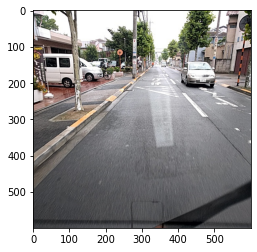

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


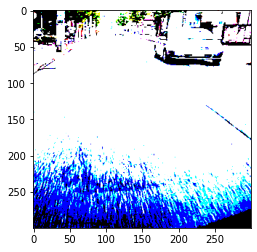

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


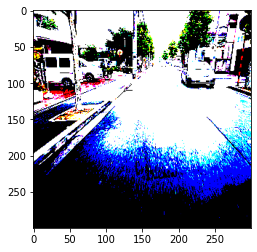

In [100]:
# 動作の確認

# 1. 画像読み込み
image_file_path = train_img_list[1]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# 2. アノテーションをリストに
transform_anno = Anno_xml2list(damageTypes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)

# 5. train画像の表示
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val画像の表示
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
# damagedatasetのDatasetを作成する

class DamageDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    transform_anno : object
        xmlのアノテーションをリストに変換するインスタンス
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train もしくは valを指定
        self.transform = transform  # 画像の変形
        self.transform_anno = transform_anno  # アノテーションデータをxmlからリストへ

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のテンソル形式のデータとアノテーションを取得
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''前処理をした画像のテンソル形式のデータ、アノテーション、画像の高さ、幅を取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
        height, width, channels = img.shape  # 画像のサイズを取得

        # 2. xml形式のアノテーション情報をリストに
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. 前処理を実施
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 色チャネルの順番がBGRになっているので、RGBに順番変更
        # さらに（高さ、幅、色チャネル）の順を（色チャネル、高さ、幅）に変換
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBoxとラベルをセットにしたnp.arrayを作成、変数名「gt」はground truth（答え）の略称
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width

In [108]:
# 動作確認
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = DamageDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(damageTypes))

val_dataset = DamageDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(damageTypes))


# データの取り出し例
val_dataset.__getitem__(1)

(tensor([[[132.0000, 132.0000, 132.0000,  ..., 132.0000, 132.0000, 132.0000],
          [132.0000, 132.0000, 132.0000,  ..., 132.0000, 132.0000, 132.0000],
          [132.0000, 132.0000, 132.0000,  ..., 132.0000, 132.0000, 132.0000],
          ...,
          [-80.2500, -78.2500, -74.0000,  ..., -89.0000, -79.2500, -89.2500],
          [-77.0000, -72.0000, -76.2500,  ..., -82.7500, -93.7500, -82.2500],
          [-72.0000, -70.0000, -78.5000,  ..., -74.2500, -70.5000, -97.5000]],
 
         [[138.0000, 138.0000, 138.0000,  ..., 138.0000, 138.0000, 138.0000],
          [138.0000, 138.0000, 138.0000,  ..., 138.0000, 138.0000, 138.0000],
          [138.0000, 138.0000, 138.0000,  ..., 138.0000, 138.0000, 138.0000],
          ...,
          [-74.2500, -72.2500, -68.0000,  ..., -83.0000, -73.2500, -82.2500],
          [-71.0000, -66.0000, -70.2500,  ..., -76.7500, -87.7500, -75.2500],
          [-66.0000, -64.0000, -72.5000,  ..., -68.2500, -64.5000, -90.5000]],
 
         [[151.0000, 151.000

# 2-3

In [0]:
def od_collate_fn(batch):
    """
    Datasetから取り出すアノテーションデータのサイズが画像ごとに異なります。
    画像内の物体数が2個であれば(2, 5)というサイズですが、3個であれば（3, 5）など変化します。
    この変化に対応したDataLoaderを作成するために、
    カスタイマイズした、collate_fnを作成します。
    collate_fnは、PyTorchでリストからmini-batchを作成する関数です。
    ミニバッチ分の画像が並んでいるリスト変数batchに、
    ミニバッチ番号を指定する次元を先頭に1つ追加して、リストの形を変形します。
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0] は画像imgです
        targets.append(torch.FloatTensor(sample[1]))  # sample[1] はアノテーションgtです

    # imgsはミニバッチサイズのリストになっています
    # リストの要素はtorch.Size([3, 300, 300])です。
    # このリストをtorch.Size([batch_num, 3, 300, 300])のテンソルに変換します
    imgs = torch.stack(imgs, dim=0)

    # targetsはアノテーションデータの正解であるgtのリストです。
    # リストのサイズはミニバッチサイズです。
    # リストtargetsの要素は [n, 5] となっています。
    # nは画像ごとに異なり、画像内にある物体の数となります。
    # 5は [xmin, ymin, xmax, ymax, class_index] です

    return imgs, targets

In [110]:
# データローダーの作成

batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
images, targets = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size())  # ミニバッチのサイズのリスト、各要素は[n, 5]、nは物体数

torch.Size([4, 3, 300, 300])
4
torch.Size([1, 5])


In [111]:
print(train_dataset.__len__())
print(val_dataset.__len__())

1320
330


# 2-4